In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,3)

In [21]:
from scipy.special import roots_jacobi
from scipy.special import comb
# Algorithm Compute_binomial_coefficients
# Input : N
# Output: all binomial coefficients binom(n, j) for j=0,..,n, for n=0,...,N 
def Compute_binomial_coefficients(N):
    # compute all binomial coefficients
    Cb = []
    for n in range(0,N+1):
        c = []
        for j in range(n+1):
            c.append(comb(n,j))
        Cb.append(c)
    return Cb

# Algorithm Convective1d
# Input : K, n
# Output: local convective matrix using polynmials of degree n
#         int_K B_j^{n}(x) * d/dx B_i^{n}(x) dx
def Convective1d(K, n):
    # Compute convective matrix 
    if n == 0:
        return np.zeros((n+1,n+1), dtype=np.float64) 
    d = 1
    # grad \lambda_k = - |\gamma_k|/(d|K|) n_{K}
    hK = abs(K[1]-K[0])
    gradlambda = [-1.0/hK, 1.0/hK]
    mutilde = np.zeros((2*n-2+2,d+1))
    muA = Compute_mu(K, 2*n-1)
    for l in range(0, d+1):
        mutilde[:,l] = muA*gradlambda[l]
    B = np.zeros((n+1,n+1), dtype=np.float64)
    for alpha0 in range(0,n+1):
        for beta0 in range(0,n):
            w0 = Cb[alpha0+beta0][alpha0]/Cb[2*n-1][n-1] #comb(alpha0+beta0, alpha0)/comb(2*n-1, n-1)
            w1 = w0*Cb[(n)-alpha0 + (n-1)-beta0][(n)-alpha0] #w0*comb((n-1)-alpha0+(n)-beta0, (n-1)-alpha0)
            for l in range(0,d+1):
                B[alpha0,beta0+l] += n*w1*mutilde[alpha0+beta0,l]
    return B

# Algorithm Mass1d
# Input : K, n, c
# Output: local mass matrix using polynmials of degree n
#         int_K B_j^{n}(x) * c(x) * B_i^{n}(x) dx
def Mass1d(K, n, c):
    d = 1
    mu = Compute_mu(K, 2*n,c)
    M = np.zeros((n+1,n+1), dtype=np.float64)
    for alpha0 in range(0,n+1):
        for beta0 in range(0,n+1):
            w0 = Cb[alpha0+beta0][alpha0]/Cb[2*n][n] #comb(alpha0+beta0, alpha0)/comb(2*n, n)
            w1 = w0*Cb[(n)-alpha0 + (n)-beta0][(n)-alpha0]#w0*comb((n)-alpha0+(n)-beta0, (n)-alpha0)
            M[alpha0,beta0] += w1*mu[alpha0+beta0]
    return M

# Algortihm  Compute_mu
# Input : element K, n, f
# Output: Bernstein Bezier moments of degree n of a funcion f
from math import ceil
def Compute_mu(K, n, f=None, q=None):
    # compute the Bernstein Bezier moments of a function f
    # dimension
    d = 1
    # number of quadrature points
    if q is None or q <= 0.5*(n+1)+1:
        q = ceil(0.5*(n+1))+2
    q = ceil(0.5*(n+1))+10
    
    if f is None:
        F0 = np.ones(q)
        mu = abs(K[1]-K[0])/d*Moment(F0,q,n)
    else:
        # Gauss-Jacobi points
        xiv, omegav = roots_jacobi(q, alpha=0, beta=0, mu=False)
        # transformation from (-1,1) to K = (a,b)
        xK = 0.5*(K[0]*(1-xiv) + K[1]*(1+xiv))
        mu = abs(K[1]-K[0])/d*Moment(f(xK), q,n)
    return mu

# Algorithm Moment(F0, q)
# Input : Array F0 corresponding to values of a function f at Stroud nodes
# Output: Array Fd composed of Bernstein-Bezier moments of f using Stroud rule
def Moment(F0, q,n):
    d = 1
    Fnew = F0.copy()
    for l in range(1, d+1):
        Fold = Fnew
        Fnew = MomentStep(Fold, l, q,n)
    return Fnew


# Algorithm MomentStep(Fin, l, q)
# Input : Array Fin and index l in {1,...,d}
# Output: Updated array Fout with index il switched to alphal
def MomentStep(Fin, l, q, n):
    xiv, omegav = roots_jacobi(q, alpha=0, beta=0, mu=False)
    xiv += 1.0
    xiv *= 0.5
    omegav *= 0.5
    
    Fout = np.zeros(n+1)
    for il in range(0,q):
        xi    = xiv[il]
        omega = omegav[il]
        s     = 1-xi
        r     = xi/s
        w = omega*s**n
        for alphal in range(0, n+1):
            Fout[alphal] += w*Fin[il]
            w *= r*(n-alphal)/(1+alphal)
    return Fout

# Algorithm for interpolation
def NewtonBernstein(f, x=None):
    n = f.size-1
    if x is None:
        x = np.linspace(0, 1, n+1, endpoint=True)

    c = np.zeros(n+1, dtype = np.float64)
    w = np.zeros(n+1, dtype = np.float64)

    c[0] = f[0]
    w[0] = 1.0
    for s in range(1,n+1):
        for k in range(n, s-1, -1):
            f[k] = (f[k]-f[k-1])/(x[k]-x[k-s])
        for k in range(s, 0,-1):
            w[k] = (k/s)*w[k-1]*(1-x[s-1]) - (1-k/s)*w[k]*x[s-1]
            c[k] = (k/s)*c[k-1] + (1-k/s)*c[k] + f[s]*w[k]
        w[0] = -w[0]*x[s-1]
        c[0] = c[0] + f[s]*w[0]
    return c

def de_casteljau(t, coefs, t0=0.0, tf=1.0):
    beta = [c for c in coefs] # values in this list are overridden
    n = len(beta)
    for j in range(1, n):
        for k in range(n - j):
            # beta[k] = beta[k] * (tf - t)/(tf - t0) + beta[k + 1] * (t - t0)/(tf - t0)
            beta[k] = beta[k] * (tf - t) + beta[k + 1] * (t - t0)
    return beta[0]

In [4]:
def Compute_HDG_p( c, f, uhat = np.array([0,0]), p=2 ):
    # Local Matrices
    global Cb 
    Cb = Compute_binomial_coefficients(max(2*p,p))
    
    K = np.array([0,1.0], dtype=np.float64)

    # Local load vector
    Fi = Compute_mu(K, p, f)

    # Local Matrices
    Bi = Convective1d(K, p)
    Mi = Mass1d(K, p, c)
    Si = np.zeros((p+1,p+1)); Si[0,0] = 1.0; Si[p,p] = 1.0
    Ei = np.zeros((2,p+1))  ; Ei[0,0] = 1.0; Ei[1,p] = 1.0
    Ci = np.zeros((2,p+1))  ; Ci[0,0] = -1.0; Ci[1,p] = 1.0
    Gi = np.eye(2)

    # condensation
    Qp = np.vstack(( np.hstack(( Mi, -Bi.T)),  np.hstack(( Bi, Si)) ))
    CEi = np.hstack(( Ci, Ei ))
    R = np.linalg.solve(Qp, np.vstack(( Ci.T, -Ei.T )))
    Ai =  -CEi @ R - Gi
    Rb = np.linalg.solve(Qp, np.hstack((np.zeros(p+1), Fi )))
    bi = -CEi @ Rb

    qu = Rb-R.dot(uhat)
    qh = qu[0:(p+1)]
    uh = qu[(p+1):2*(p+1)]

    return uh, qh

In [5]:
from sympy import *
xsym = Symbol('xsym')

In [7]:
def generate_all_plots(x0, xf, forcing, coefficient, uh, qh, order=None, uexact=None, qexact = None):
    if order is None: order= uh.size-1

    fig, ax = plt.subplots(4,1, figsize=(15,12))
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['mathtext.fontset'] = "cm"
    SMALL_SIZE = 16
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 24
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    xplot = np.linspace(x0,xf,200)

    lw=4
    ax[0].plot(xplot, forcing(xplot), linewidth=lw, label=r'$f$')
    ax[0].title.set_text('forcing')
    ax[0].set_xlim(0,1)
    ax[0].legend()

    ax[1].plot(xplot, coefficient(xplot),linewidth=lw, label=r'$a$')
    ax[1].title.set_text('coefficient')
    ax[1].set_xlim(0,1)
    ax[1].legend()

    uhplot = [de_casteljau(t, uh) for t in xplot]
    ax[2].plot(xplot, uhplot, '.', linewidth=lw, label=r'$u_h$')
    if uexact is not None:
        ax[2].plot(xplot, uexact(xplot), '--', linewidth=lw, label=r'$u$')
    ax[2].title.set_text(r'variable $u$, order = %i' %order)
    ax[2].set_xlim(0,1)
    ax[2].legend()

    qhplot = [de_casteljau(t, qh) for t in xplot]
    ax[3].plot(xplot, qhplot, linewidth=lw,label=r'$q_h$')
    if qexact is not None:
        ax[3].plot(xplot, qexact(xplot), '--', linewidth=lw, label=r'$q$')
    ax[3].title.set_text(r'variable $q$, order = %i' %order)
    ax[3].set_xlim(0,1)
    ax[3].legend()

    plt.tight_layout()
    plt.show()


# Example 1

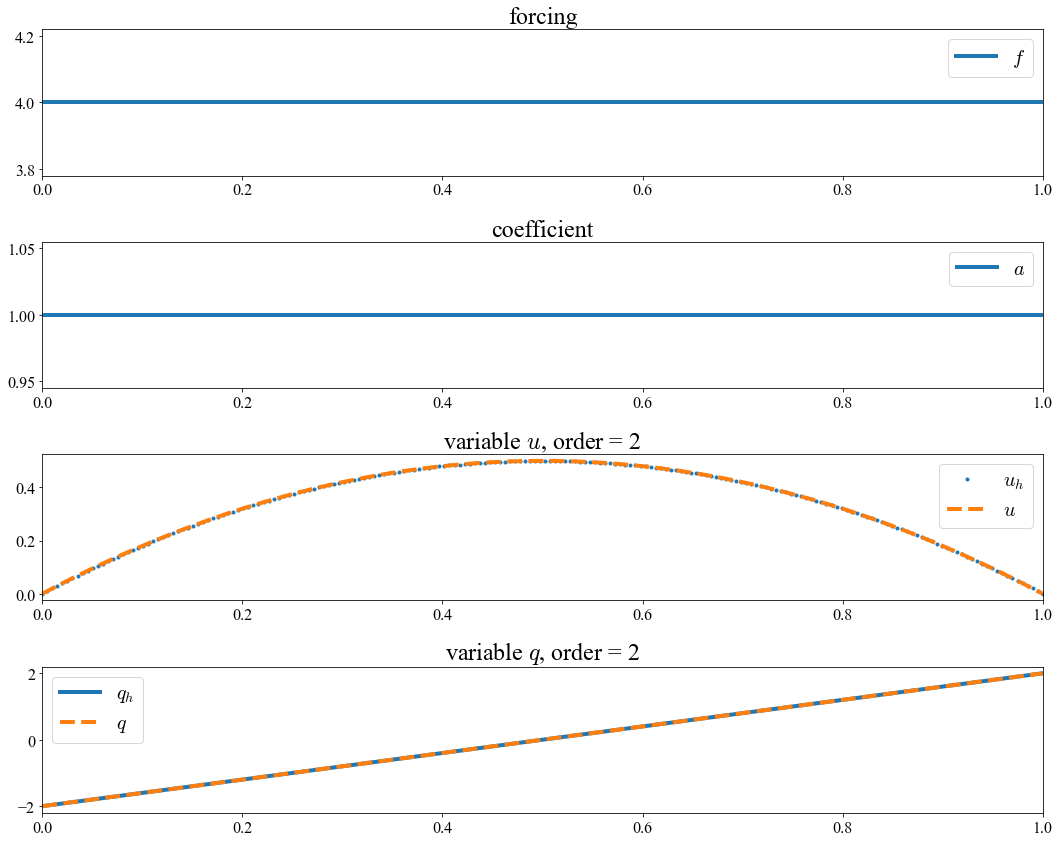

In [307]:
c = lambda x: 1.0+0*x
a = lambda x: 1.0/c(x)
uexact_sym = 2.0*(1.0-xsym)*xsym
fsym = diff(diff(uexact_sym, xsym),xsym)

uexact = lambda x: 2.0*(1.0-x)*x
qexact = lambda x: 4*x-2
f = lambda x: 0*x + 4.0
uh, qh = Compute_HDG_p( c, f, uhat = np.array([0,0]), p=2 )

generate_all_plots(x0=0, xf=1.0, 
                   forcing=f, 
                   coefficient=a,
                   uh=uh, 
                   qh=qh, 
                   uexact = uexact, 
                   qexact = qexact)

# Example 2

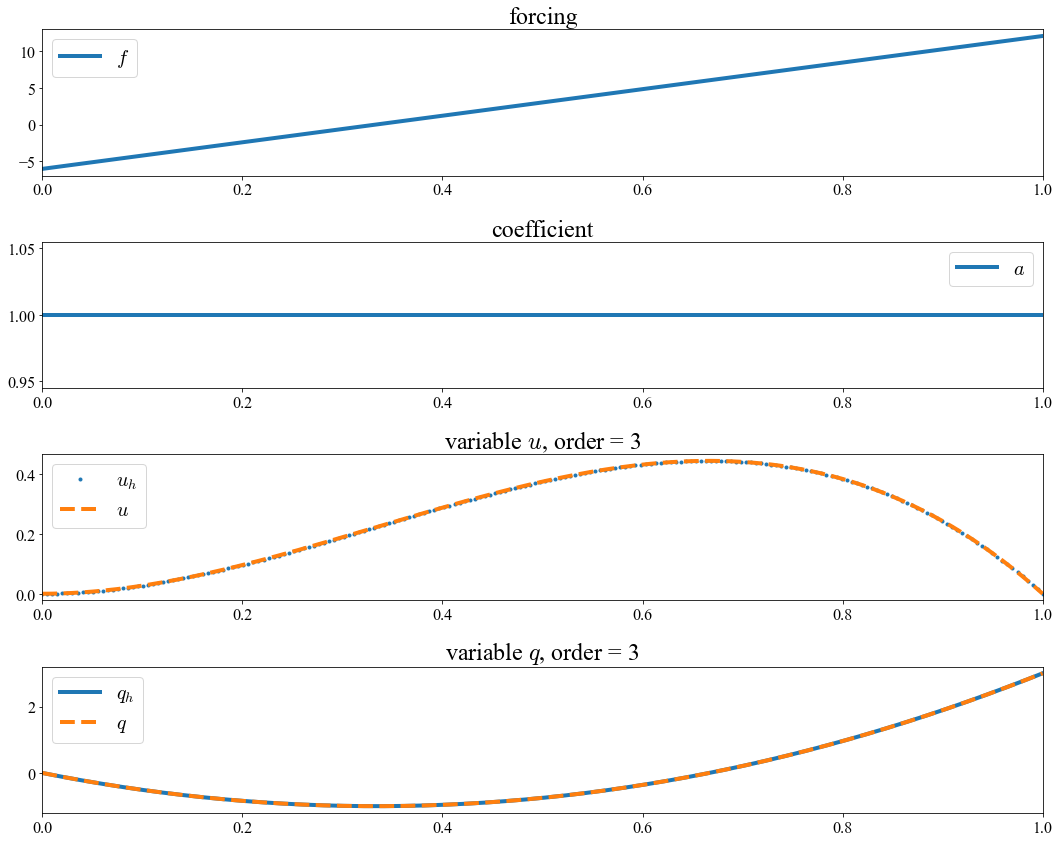

In [309]:
c = lambda x: 1.0+0*x

uexact_sym = 3.0*(1.0-xsym)*xsym**2
fsym = diff(diff(uexact_sym, xsym),xsym)


uexact = lambda x: 3.0*(1.0-x)*x**2
qexact = lambda x: -3.0*(2*x-3*x**2)
f = lambda x: -(6.0 - 18.0*x)
uh, qh = Compute_HDG_p( c, f, uhat = np.array([0,0]), p=3 )

generate_all_plots(x0=0, xf=1.0, 
                   forcing=f, 
                   coefficient=a,
                   uh=uh, 
                   qh=qh, 
                   uexact = uexact, 
                   qexact = qexact)

# Example 3

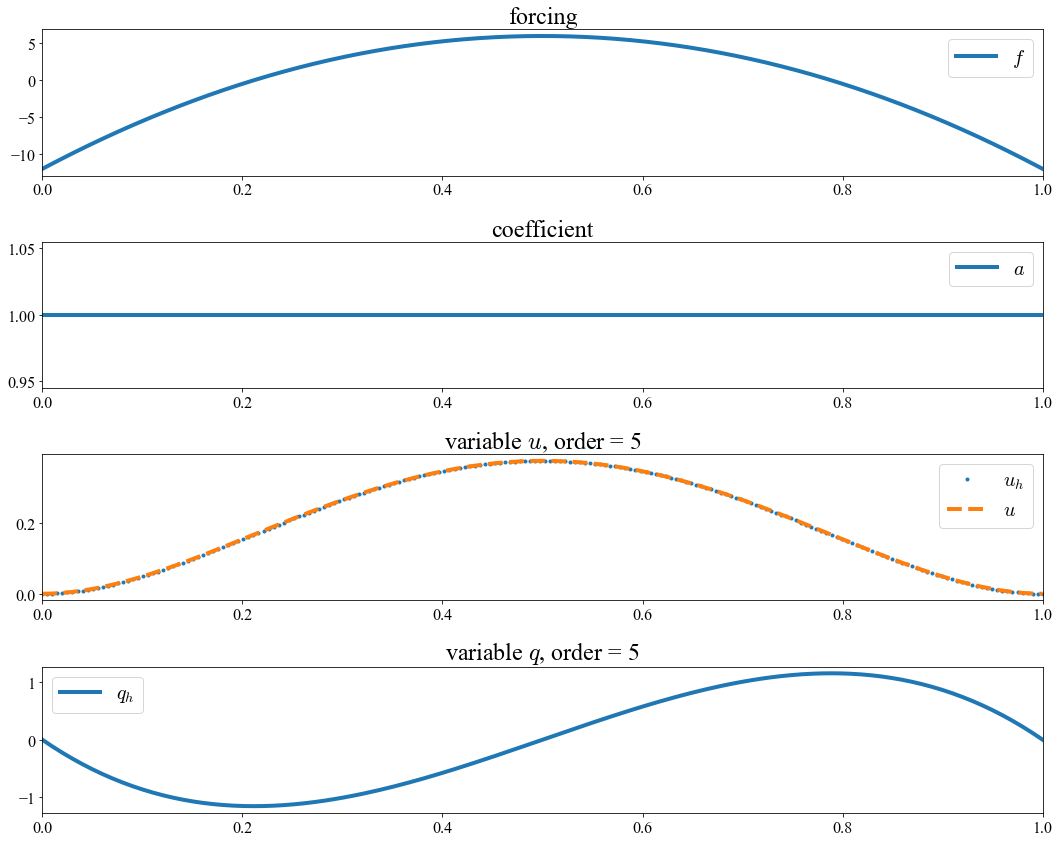

In [310]:
c = lambda x: 1.0+0*x

uexact_sym = 6.0*(1.0-xsym)**2*xsym**2
fsym = diff(diff(uexact_sym, xsym),xsym)

uexact = lambda x: 6.0*(1.0-x)**2*x**2
f = lambda x: -(12.0*x**2 + 24.0*x*(2*x - 2.0) + 12.0*(1.0 - x)**2)
uh, qh = Compute_HDG_p( c, f, uhat = np.array([0,0]), p=5 )

generate_all_plots(x0=0, xf=1.0, 
                   forcing=f, 
                   coefficient=a,
                   uh=uh, 
                   qh=qh, 
                   uexact = uexact, 
                   qexact = None)

# Example 4

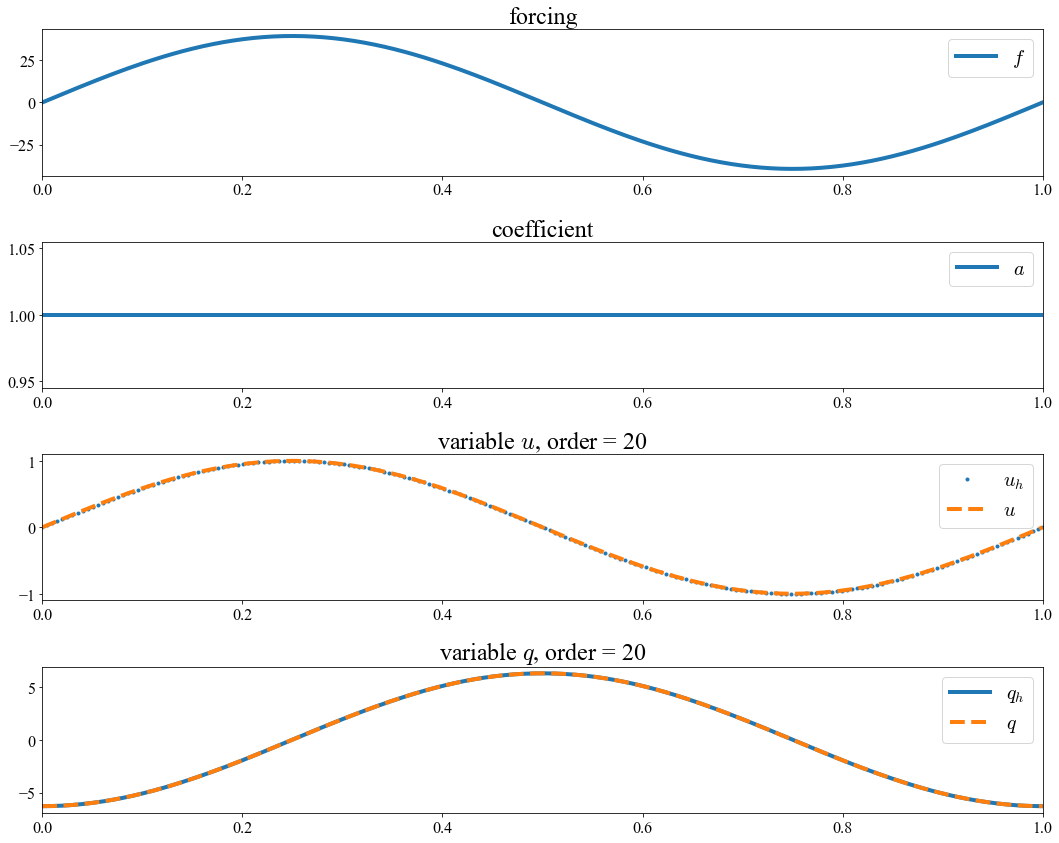

In [311]:
uexact = lambda x: np.sin(2*np.pi*x)
qexact = lambda x: -2*np.pi*np.cos(2*np.pi*x)
f = lambda x: (4.0*np.pi**2*np.sin(2*np.pi*x))
uh, qh = Compute_HDG_p( c, f, uhat = np.array([0,0]), p=20 )
generate_all_plots(x0=0, xf=1.0, 
                   forcing=f, 
                   coefficient=a,
                   uh=uh, 
                   qh=qh, 
                   uexact = uexact, 
                   qexact = qexact)

# Example 5

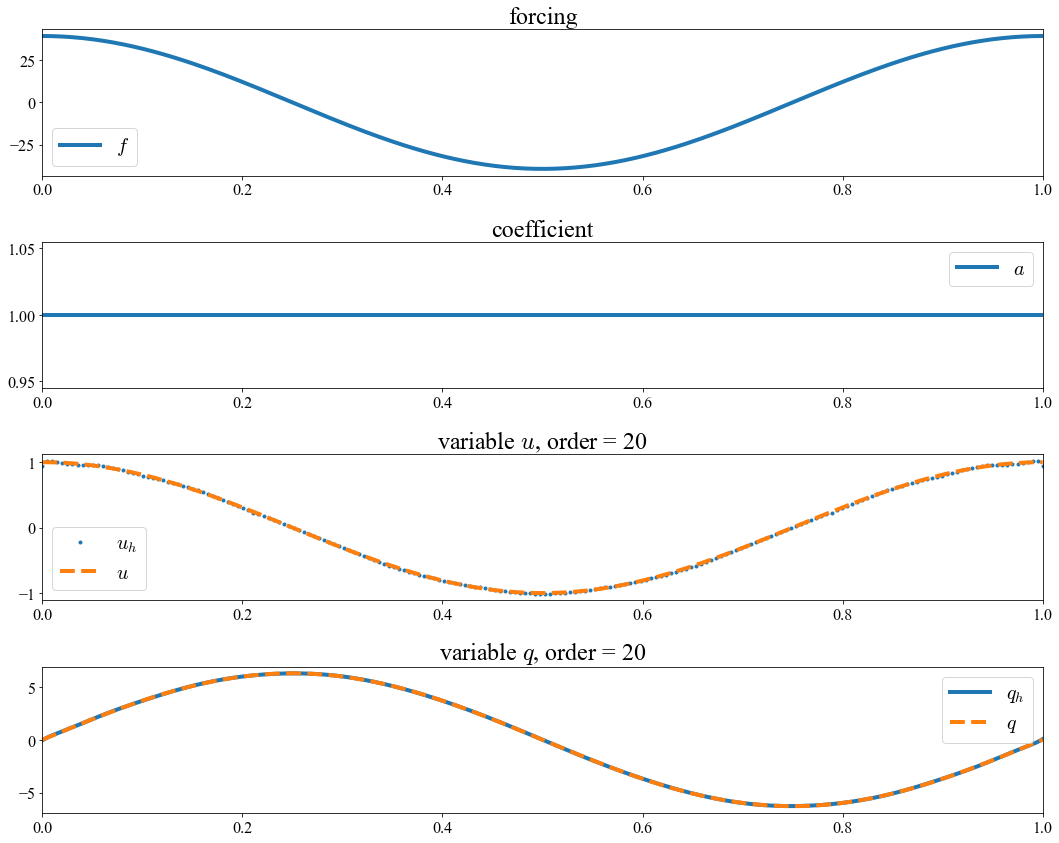

In [312]:
uexact = lambda x: np.cos(2*np.pi*x)
qexact = lambda x: 2*np.pi*np.sin(2*np.pi*x)
f = lambda x: (4.0*np.pi**2*np.cos(2*np.pi*x))
uh, qh = Compute_HDG_p( c, f, uhat = np.array([1.0,1.0]), p=20 )
generate_all_plots(x0=0, xf=1.0, 
                   forcing=f, 
                   coefficient=a,
                   uh=uh, 
                   qh=qh, 
                   uexact = uexact, 
                   qexact = qexact)

# Example 6

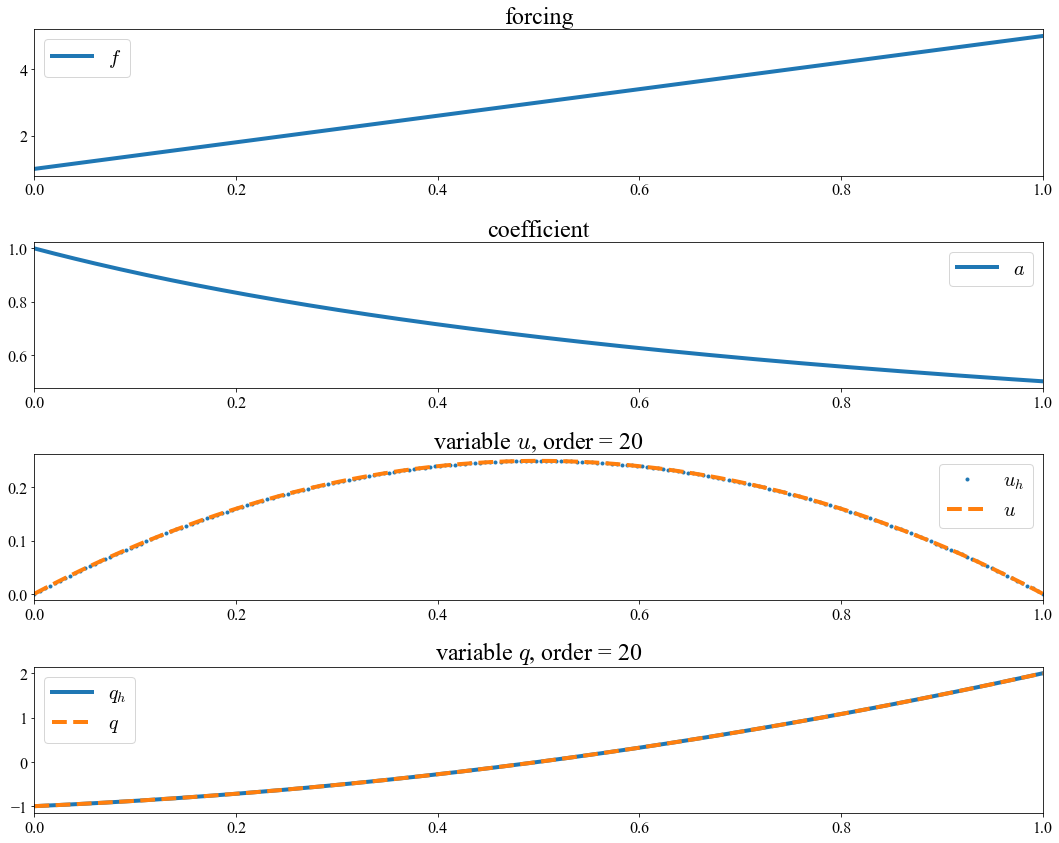

In [313]:
c = lambda x: 1.0*(x+1)
a = lambda x: 1.0/c(x)
uexact = lambda x: x*(1-x)
qexact = lambda x: -c(x)*(-2*x+1)
f = lambda x: 4.0*x + 1.0
uh, qh = Compute_HDG_p( a, f, uhat = np.array([0.0,0.0]), p=20 )
generate_all_plots(x0=0, xf=1.0, 
                   forcing=f, 
                   coefficient=a,
                   uh=uh, 
                   qh=qh, 
                   uexact = uexact, 
                   qexact = qexact)

# Example 7

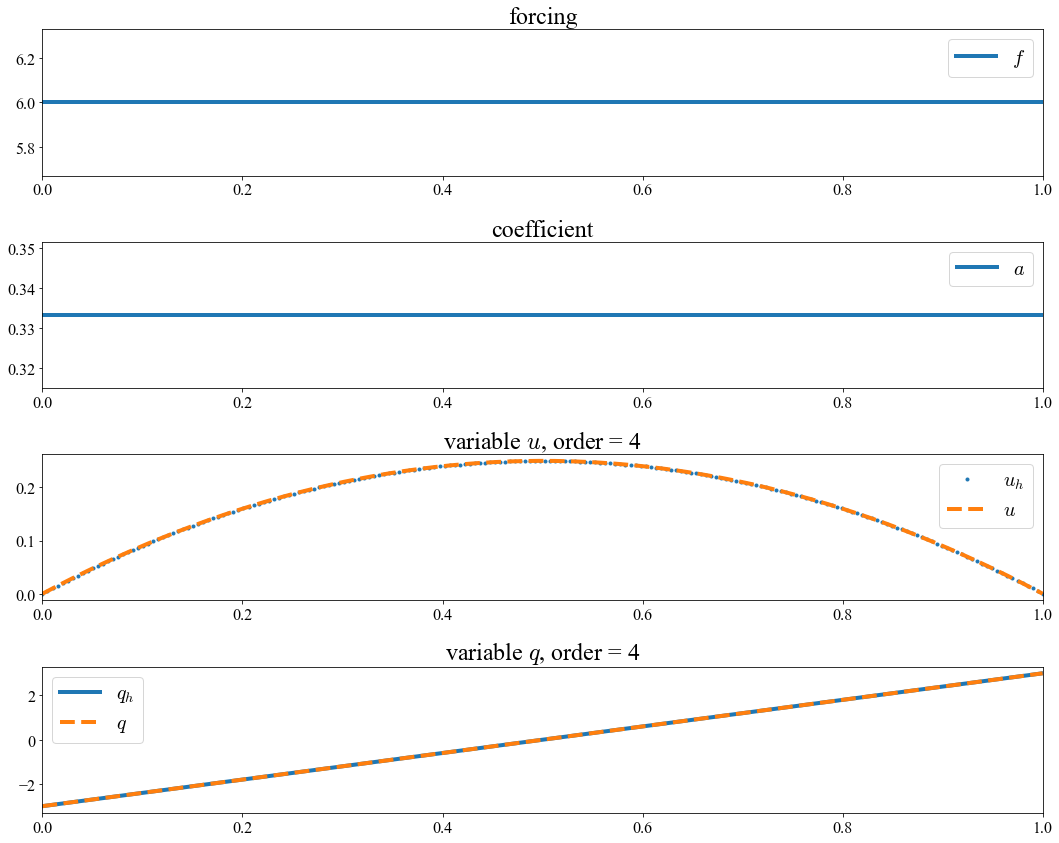

In [314]:
uexact = lambda x: x*(1.0-x)
c = lambda x: .0*x+3.0
a = lambda x: 1.0/c(x)
qexact = lambda x: -c(x)*(-2.0*x+1.0)
f = lambda x: 6.0 + 0*x
uh, qh = Compute_HDG_p( a, f, uhat = np.array([0.0,0.0]), p=4 )
generate_all_plots(x0=0, xf=1.0, 
                   forcing=f, 
                   coefficient=a,
                   uh=uh, 
                   qh=qh, 
                   uexact = uexact, 
                   qexact = qexact)

# Example 8

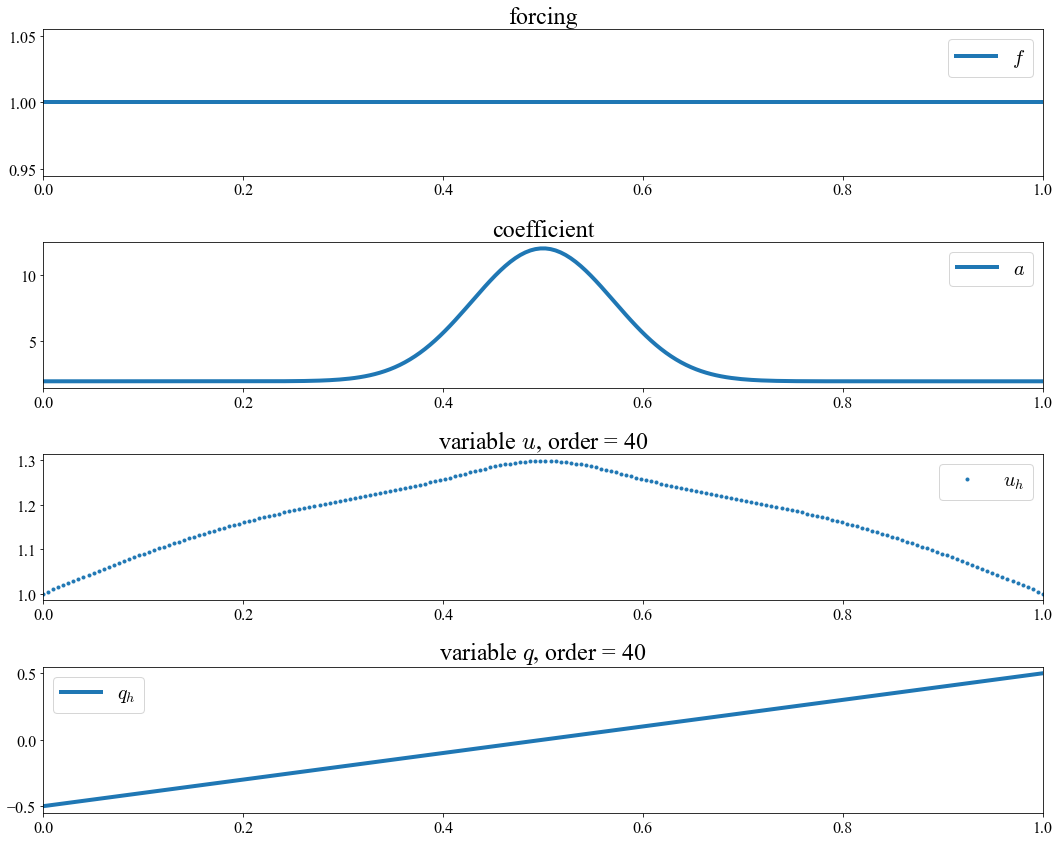

In [315]:

L = 10.0
a = lambda x: 2.0 + 10*np.exp(-1.0/(1.0/L**2-((x-0.5)/L)**2))*np.exp(L**2) 
# a = lambda x: 1.0 + np.exp(-1.0/(1.0/L**2-((x-0.25)/L)**2))*np.exp(L**2) + np.exp(-1.0/(1.0/L**2-((x-0.75)/L)**2))*np.exp(L**2)

f = lambda x: 0*x + 1.0
uh, qh = Compute_HDG_p( a, f, uhat = np.array([1.0,1.0]), p=40 )
generate_all_plots(x0=0, xf=1.0, 
                   forcing=f, 
                   coefficient=a,
                   uh=uh, 
                   qh=qh, 
                   uexact = None, 
                   qexact = None)

# Example 9     

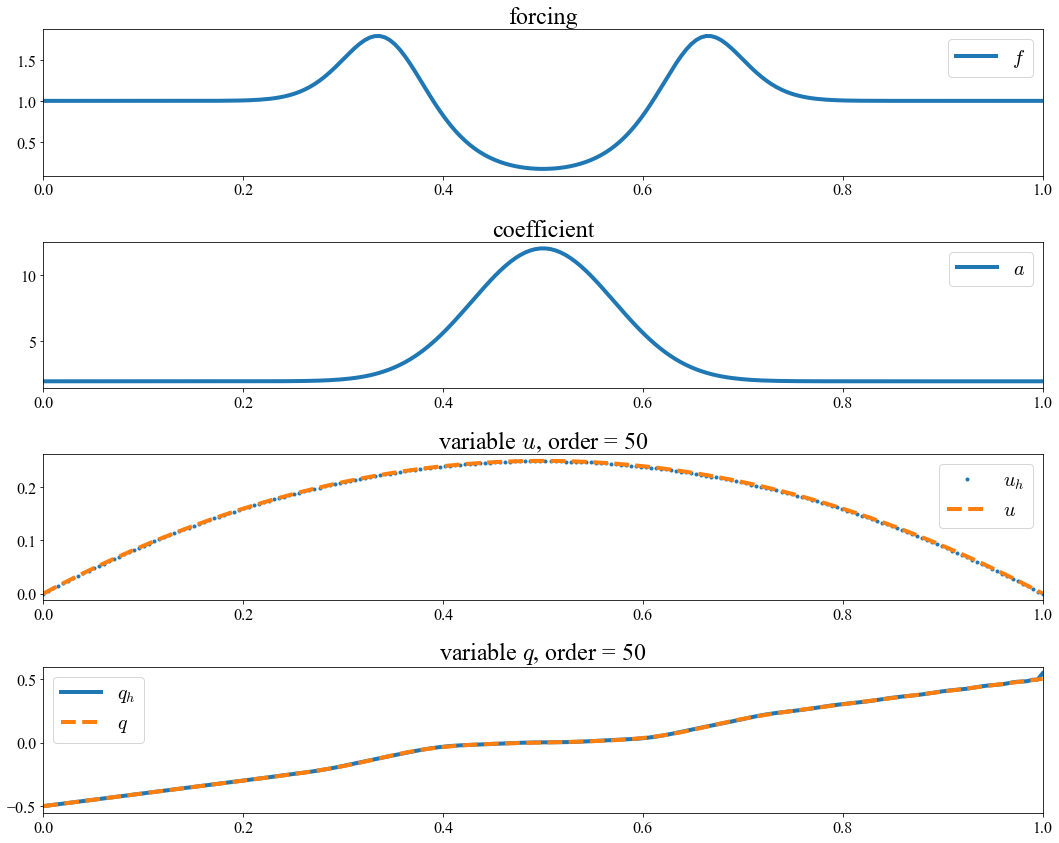

In [316]:
uexact_sym = (1-xsym)*xsym 
L = 10.0
c_sym = 1.0/(2.0 + 10*exp(-1.0/(1.0/L**2-((xsym-0.5)/L)**2))*exp(L**2) )
qexact_sym = c_sym * (2.0*xsym-1.0)
fsym = diff(qexact_sym, xsym)

# 
uexact = lambdify(xsym, uexact_sym)
qexact = lambdify(xsym, qexact_sym)
f = lambdify(xsym, fsym)

a = lambda x: 2.0 + 10*np.exp(-1.0/(1.0/L**2-((x-0.5)/L)**2))*np.exp(L**2) 
# a = lambda x: 1.0 + np.exp(-1.0/(1.0/L**2-((x-0.25)/L)**2))*np.exp(L**2) + np.exp(-1.0/(1.0/L**2-((x-0.75)/L)**2))*np.exp(L**2)

order=50
uh, qh = Compute_HDG_p( a, f, uhat = np.array([0,0]), p=order )
generate_all_plots(x0=0, xf=1.0, 
                   forcing=f, 
                   coefficient=a,
                   uh=uh, 
                   qh=qh, 
                   order = order,
                   uexact = uexact, 
                   qexact = qexact)

# Example 10

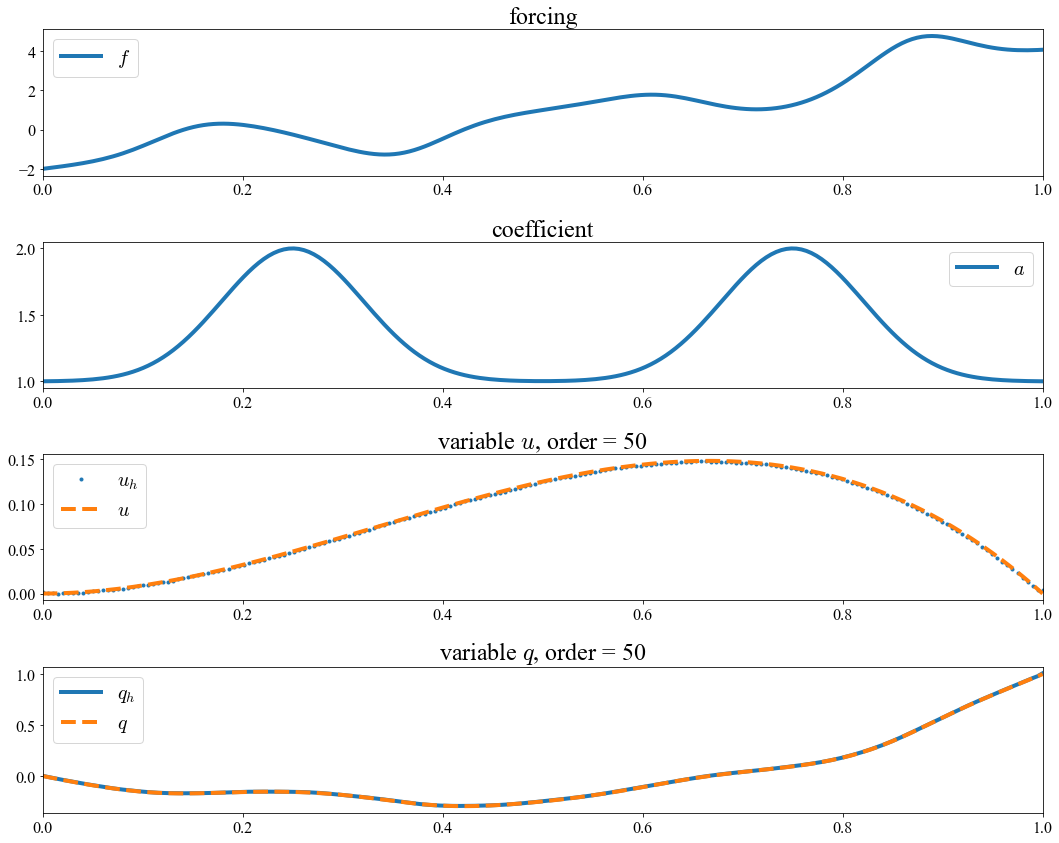

In [324]:
uexact_sym = (1-xsym)*xsym**2 
L = 10.0
c_sym = 1.0/(1.0 + exp(-1.0/(1.0/L**2-((xsym-0.25)/L)**2))*exp(L**2) + exp(-1.0/(1.0/L**2-((xsym-0.75)/L)**2))*exp(L**2))
qexact_sym = c_sym * (3.0*xsym**2-2*xsym)
fsym = diff(qexact_sym, xsym)

# 
uexact = lambdify(xsym, uexact_sym)
qexact = lambdify(xsym, qexact_sym)
f = lambdify(xsym, fsym)

a = lambda x: 1.0 + np.exp(-1.0/(1.0/L**2-((x-0.25)/L)**2))*np.exp(L**2) + np.exp(-1.0/(1.0/L**2-((x-0.75)/L)**2))*np.exp(L**2)

order=50
uh, qh = Compute_HDG_p( a, f, uhat = np.array([0,0]), p=order )
generate_all_plots(x0=0, xf=1.0, 
                   forcing=f, 
                   coefficient=a,
                   uh=uh, 
                   qh=qh, 
                   order = order,
                   uexact = uexact, 
                   qexact = qexact)

# Example 11

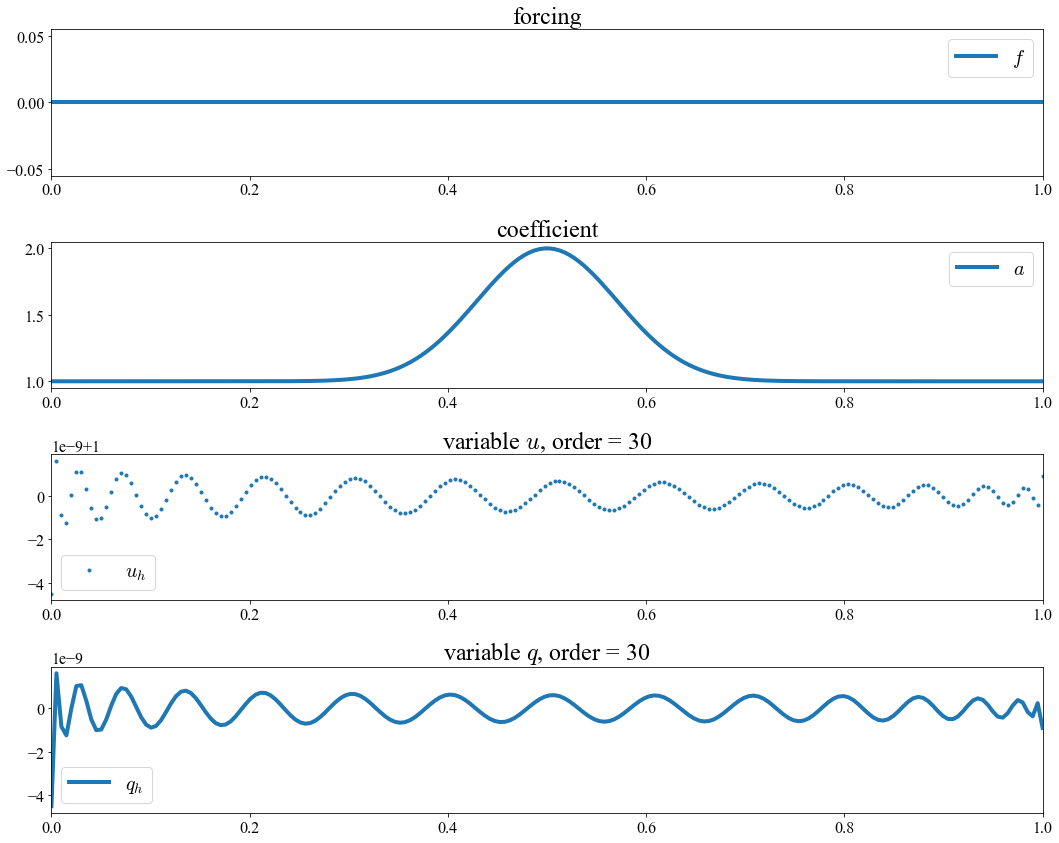

In [22]:
#uexact_sym = (1-xsym)*xsym**2 
L = 10.0
c_sym = 1.0/(1.0 + exp(-1.0/(1.0/L**2-((xsym-0.25)/L)**2))*exp(L**2) + exp(-1.0/(1.0/L**2-((xsym-0.75)/L)**2))*exp(L**2))
#qexact_sym = c_sym * (3.0*xsym**2-2*xsym)
#fsym = diff(qexact_sym, xsym)

# 
f = lambda x: 0 * x 
a = lambda x: 1.0 + np.exp(-1.0/(1.0/L**2-((x-0.5)/L)**2))*np.exp(L**2)# + np.exp(-1.0/(1.0/L**2-((x-0.75)/L)**2))*np.exp(L**2)

order = 30
uh, qh = Compute_HDG_p( a, f, uhat = np.array([1.0,1.0]), p=order )
generate_all_plots(x0=0, xf=1.0, 
                   forcing=f, 
                   coefficient=a,
                   uh=uh, 
                   qh=qh, 
                   order = order,
                   uexact = None, 
                   qexact = None)

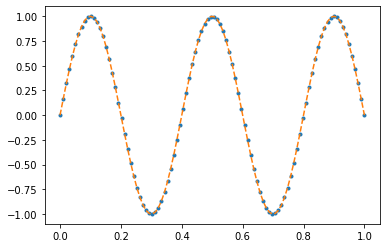

In [6]:
xx = np.linspace(0,1,15)
fun = lambda x: np.sin(5*np.pi*x)
fvals = fun(xx)
fBern = NewtonBernstein(fvals)

xplot = np.linspace(0,1,100)
fplot = [de_casteljau(t, fBern) for t in xplot]
plt.plot(xplot, fplot, '.')
plt.plot(xplot, fun(xplot), '--')
plt.show()

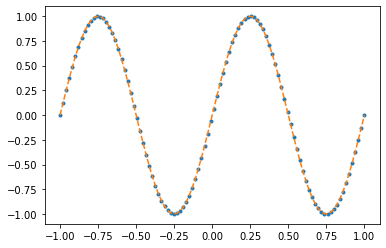

In [8]:
xx = np.linspace(-1,1,15)
fun = lambda x: np.sin(2*np.pi*x)
fvals = fun(xx)
fBern = NewtonBernstein(fvals, xx)

xplot = np.linspace(-1,1,100)
fplot = [de_casteljau(t, fBern, t0=0, tf=1) for t in xplot]
plt.plot(xplot, fplot, '.')
plt.plot(xplot, fun(xplot), '--')
plt.show()

In [283]:
g = xsym**2
dg = diff(g,xsym)
fun = lambdify(xsym, dg)
fun(2)

4